In [1]:
import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F


class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """

    def __init__(self, channels, kernel_size, sigma, dim=2, order=0, device=None):
        super(GaussianSmoothing, self).__init__()
        self.padd = kernel_size // 2
        self.dim = dim
        self.std = sigma
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())

        if order == 'xx':
            kernel[0, 0] = ((kernel[0, 0] * ((meshgrids[0].T - self.padd) ** 2 - self.std ** 2) / self.std ** 4))
        elif order == 'yy':
            kernel[0, 0] = ((kernel[0, 0] * ((meshgrids[0] - self.padd) ** 2 - self.std ** 2) / self.std ** 4))
        elif order == 'xy':
            kernel[0, 0] = kernel[0, 0] * (meshgrids[0] - self.padd) * (meshgrids[0].T - self.padd) / self.std ** 4

        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))
        kernel.requires_grad = False
        if device is not None:
            kernel = kernel.to(device)
        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, x):
        """
        Apply gaussian filter to input.
        Arguments:
            x (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        if self.dim == 2:
            x = F.pad(x, (self.padd, self.padd, self.padd, self.padd), mode='reflect')
        return self.conv(x, weight=self.weight, groups=self.groups)


In [2]:
#class of applying SoftFrangiFilter in Tensor computations

class SoftFrangiFilter2D(nn.Module):

    def __init__(self, channels, sigmas, beta, device, c=2):
        """
        Apply Soft Frangi filter on a 3d tensor.
        Arguments:
            channels (int, sequence): Number of channels of the input tensors. Output will
                have this number of channels as well.
            kernel_size (int, sequence): Size of the gaussian kernel.
            sigmas (list, sequence): List of standard deviations of the gaussian kernels.
            beta (float, sequence): Beta parameter of Frangi filter.
            beta (с, sequence): С parameter of Frangi filter.
                Default value is 2 (spatial).
        """
        super(SoftFrangiFilter2D, self).__init__()
        self.sigmas = sigmas
        self.gaus_filters = []
        self.beta = beta
        self.c = c
        for sigma in sigmas:
            self.gaus_filters.append([])
            for order in ['xx', 'yy', 'xy']:
                self.gaus_filters[-1].append(GaussianSmoothing(channels, 7, sigma, c, order, device))

    def _calc_frangi_response(self, xx, yy, xy):
        """
        Calculate Frangi filter response give the second order derivatives.
        Arguments:
            xx (torch.Tensor, sequence): (bs, channels, h, w), second order derivative on x-axis
            yy (torch.Tensor, sequence): (bs, channels, h, w), second order derivative on y-axis
            xy (torch.Tensor, sequence): (bs, channels, h, w), second order derivative on xy-axes
        """
        lambda_t1 = ((xx + yy) + torch.sqrt((xx - yy) ** 2 + 4 * xy ** 2 + 1e-6)) / 2
        lambda_t2 = ((xx + yy) - torch.sqrt((xx - yy) ** 2 + 4 * xy ** 2 + 1e-6)) / 2
        lambdas = torch.stack((lambda_t1, lambda_t2), dim=0)
        lambdas_abs, sorted_ind = torch.sort(torch.abs(lambdas), dim=0)
        lambda2_sign = (lambdas * sorted_ind).sum(dim=0)
        lambda1 = lambdas_abs[0]
        lambda2 = lambdas_abs[1]
        blobness = torch.zeros(lambda1.shape, device=lambda1.device)
        blobness[lambda2 != 0] = blobness[lambda2 != 0] + torch.exp(
            -(lambda1[lambda2 != 0] / lambda2[lambda2 != 0]) ** 2 / (2 * self.beta ** 2))
        hess_struc = (1 - torch.exp(-torch.sqrt(lambda1 ** 2 + lambda2 ** 2) ** 2 / (2 * self.c ** 2)))
        vness = blobness * hess_struc
        vness[lambda2_sign > 0] = vness[lambda2_sign > 0] * 0
        return vness, blobness, hess_struc, lambda1, lambda2

    def forward(self, img):
        """
        Apply Soft Frangi filter on a batch of images.
        Arguments:
            img (torch.Tensor, sequence): Tensor of shape (bs, channels, h, w)
        """
        frangi_resp = torch.zeros((len(self.sigmas),) + img.shape, dtype=torch.float32, device=img.device)
        for i, _ in enumerate(self.sigmas):
            xx = self.gaus_filters[i][0](img)
            yy = self.gaus_filters[i][1](img)
            xy = self.gaus_filters[i][2](img)
            vness, _, _, _, _ = self._calc_frangi_response(xx, yy, xy)
            frangi_resp[i] = vness
        # max_frangi_resp = (torch.softmax(frangi_resp, dim=0) * frangi_resp).sum(dim=0)
        return frangi_resp


In [ ]:

import numpy as np

import torch
#utilities for positional embeddings in patches for ViT model in Masked Autoencoder, highly inspired by DeiT from Facebook research

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb



# References:
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------
def interpolate_pos_embed(model, checkpoint_model):
    if 'pos_embed' in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        if orig_size != new_size:
            print("Position interpolate from %dx%d to %dx%d" % (orig_size, orig_size, new_size, new_size))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # only the position tokens are interpolated
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
            pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model['pos_embed'] = new_pos_embed

In [3]:
# general code for utilizing MaskedAutoencoder Visual Transformer Model with Encoder-Decoder architecture design and so on. Contains Guided Masking function
from functools import partial
import torch
import torch.nn as nn
from timm.models.vision_transformer import PatchEmbed, Block
import cv2
import numpy as np
from skimage.filters import frangi
from skimage import exposure
import matplotlib.pyplot as plt

class MaskedAutoencoderViT(nn.Module):
    """Masked Autoencoder with Vision Transformer backbone"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_norm=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_norm=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True)  # decoder to patch

        self.norm_pix_loss = norm_pix_loss
        self.frangi = SoftFrangiFilter2D(channels=1, sigmas=range(2,10,1), beta=0.5, c=2, device="cuda")
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize positional embeddings and patch embeddings
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # Initialize weights for patch embedding
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # Initialize weights for linear and layer norm layers
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """Patchify input images"""
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(imgs.shape[0], 3, h, p, w, p)
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(imgs.shape[0], h * w, p**2 * 3)
        return x

    def unpatchify(self, x):
        """Unpatchify input sequences"""
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(x.shape[0], h, w, p, p, 3)
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(x.shape[0], 3, h * p, h * p)
        return imgs
    
    def guided_masking(self, x, mask_ratio, sigma=0.05):
        patch_size = self.patch_embed.patch_size[0]
        N, L, D = x.shape
        num_patches = int(np.sqrt(L))
        noise = torch.zeros(N, L, device=x.device)
        len_keep = int(L * (1 - mask_ratio))
        imgs = x.clone()
        imgs = self.unpatchify(imgs).mean(dim=1, keepdim=True)

        response = self.frangi(imgs)
        response = torch.cat((torch.zeros_like(response[0:1]), response), dim=0)
        response = torch.max(response, dim=0)[0]

        patches = response.reshape((N, num_patches,patch_size,num_patches,patch_size))
        patches = torch.einsum("nhawb->nhwab", patches)
        patches = patches.reshape((N,num_patches,num_patches,patch_size*patch_size))
        patches = patches.mean(axis=-1)
        patches += torch.randn_like(patches) * sigma
        noise = patches.view(N, -1)

        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        # x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return ids_keep, mask, ids_restore

    def forward_encoder(self, x, mask_ratio, sigma=0.05):
        patches = self.patchify(x.clone())
        ids_keep, mask, ids_restore = self.guided_masking(patches, mask_ratio, sigma=sigma)
        # embed patches

        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, x.shape[-1]))

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)
        loss = (loss * mask).sum() / mask.sum()
        return loss

    def forward(self, imgs, mask_ratio=0.75, sigma=0.05):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio, sigma)
        pred = self.forward_decoder(latent, ids_restore)
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask
    
    
def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_large_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_huge_patch14_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=14, embed_dim=1280, depth=32, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
mae_vit_base_patch16 = mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_large_patch16 = mae_vit_large_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_huge_patch14 = mae_vit_huge_patch14_dec512d8b  # decoder: 512 dim, 8 blocks

In [10]:
#code for running image tests on reconstruction for pretrained model
import matplotlib.pyplot as plt

# Define the ImageNet normalization values
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
def show_image(image, title=''):
    """
    Function to display an image. The image should be in [H, W, 3] format
    and normalized in the range [0, 1].
    """
    assert image.shape[2] == 3  # Ensure the image has 3 channels
    # Denormalize the image from ImageNet statistics
    image = (image * imagenet_std + imagenet_mean)  # Denormalize to ImageNet range
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

def run_one_image(img, model, mask_ratio=0.75, sigma=0.05):
    """
    Function to run a single image through the MAE model, and display:
    - Original image
    - Masked image
    - Reconstructed image
    - Reconstructed + visible patches
    """
    # Normalize the image for ImageNet
    img = (img - imagenet_mean) / imagenet_std

    # Convert image to a PyTorch tensor (from NumPy array)
    img = torch.tensor(img, dtype=torch.float32)

    # Move the image tensor to CUDA (GPU) if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img = img.to(device)

    # Make sure the model is also moved to CUDA
    model = model.to(device)

    # Add batch dimension to image
    x = img.unsqueeze(dim=0)  # Add batch dimension
    x = torch.einsum('nhwc->nchw', x)  # Convert HWC to NCHW format

    # Run the model (using guided masking and reconstruction)
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio, sigma=sigma)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu().numpy()

    # Ensure mask is on the same device as input and output
    mask = mask.detach().to(device)
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 * 3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu().numpy()

    x = torch.einsum('nchw->nhwc', x).cpu().numpy()

    # Masked image (visible patches replaced by 0)
    im_masked = x * (1 - mask)

    # MAE reconstruction with visible patches
    im_paste = x * (1 - mask) + y * mask

    # Display the results
    plt.rcParams['figure.figsize'] = [24, 24]

    # Original image
    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    # Masked image
    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    # Reconstruction
    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    # Reconstruction + visible patches
    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()


In [11]:
def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # Define model dictionary
    model_dict = {
        'mae_vit_base_patch16': mae_vit_base_patch16_dec512d8b,
        'mae_vit_large_patch16': mae_vit_large_patch16_dec512d8b,
        'mae_vit_huge_patch14': mae_vit_huge_patch14_dec512d8b,
    }
    
    # Check if the arch exists in the dictionary
    if arch not in model_dict:
        raise ValueError(f"Architecture '{arch}' is not defined in the model dictionary.")
    
    # Build model
    model = model_dict[arch]()
    
    # Load model checkpoint
    checkpoint = torch.load(chkpt_dir, map_location='cuda')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    
    return model


In [14]:
model_mae=prepare_model(r'C:\Users\Shakhnazar\Desktop\Research\checkpoint-100_Guided_MAE.pth', 'mae_vit_base_patch16')
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')

<All keys matched successfully>


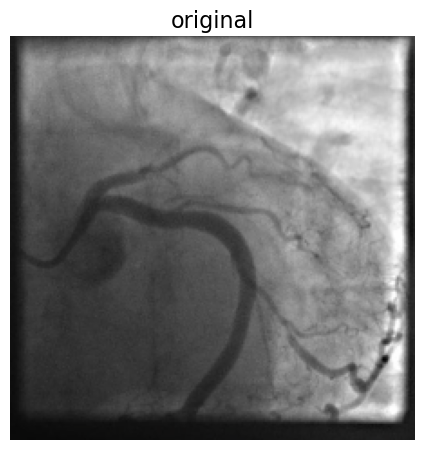

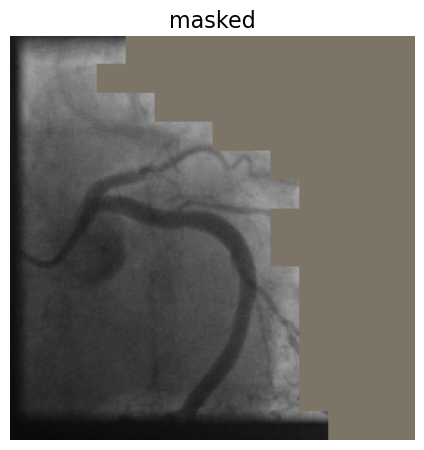

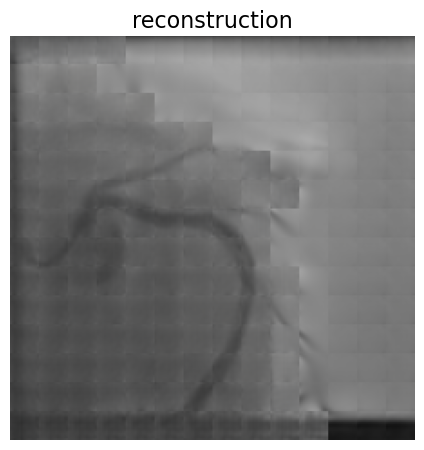

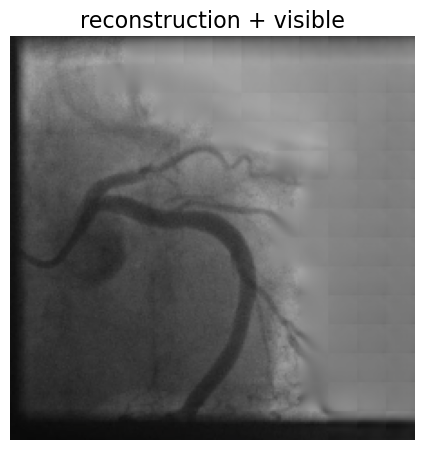

In [19]:

model_mae.eval()

# Load an example image
image_path =r"C:\Users\Shakhnazar\Desktop\SWIN_MAE_DATA\data\train\14_006_1_0100_bmp.rf.f412cd0318472e44e252f1ebb30f341f.jpg"  # Replace with your image path
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV format) to RGB
img = cv2.resize(img, (224, 224))  # Resize to match the model's input size
img = img / 255.0  # Normalize image to range [0, 1]

# Run the image through the model
run_one_image(img, model_mae, mask_ratio=0.4, sigma=1)